<a href="https://www.kaggle.com/code/avtnshm/daily-power-generation-in-india-forecast?scriptVersionId=149246709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.simplefilter('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-power-generation-in-india-2013-2023/Daily_Power_Gen_Source_march_23.csv
/kaggle/input/daily-power-generation-in-india-2013-2023/Daily_Power_Gen_States_march_23.csv


In [2]:
df= pd.read_csv('/kaggle/input/daily-power-generation-in-india-2013-2023/Daily_Power_Gen_States_march_23.csv')
df.isna().sum() #Cchecing null values

Region                                 0
States                                 0
Max.Demand Met during the day(MW)      0
Shortage during maximum Demand(MW)    19
Energy Met (MU)                        1
date                                   0
dtype: int64

In [3]:
#Filling null values with mean as null values are very low
df['Shortage during maximum Demand(MW)'] = df['Shortage during maximum Demand(MW)'].fillna(df['Shortage during maximum Demand(MW)'].mean())
df['Energy Met (MU)'] = df['Energy Met (MU)'].fillna(df['Energy Met (MU)'].mean())
df.isna().sum()

Region                                0
States                                0
Max.Demand Met during the day(MW)     0
Shortage during maximum Demand(MW)    0
Energy Met (MU)                       0
date                                  0
dtype: int64

In [4]:
df.head()

,Region,States,Max.Demand Met during the day(MW),Shortage during maximum Demand(MW),Energy Met (MU),date
0,NER,Mizoram,77,1.0,1.2,2015-01-01
1,WR,DD,214,0.0,4.8,2015-01-01
2,WR,Goa,383,0.0,7.3,2015-01-01
3,WR,Maharashtra,14837,57.0,315.0,2015-01-01
4,WR,MP,5740,0.0,109.8,2015-01-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126699 entries, 0 to 126698
Data columns (total 6 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Region                              126699 non-null  object 
 1   States                              126699 non-null  object 
 2   Max.Demand Met during the day(MW)   126699 non-null  int64  
 3   Shortage during maximum Demand(MW)  126699 non-null  float64
 4   Energy Met (MU)                     126699 non-null  float64
 5   date                                126699 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 5.8+ MB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Max.Demand Met during the day(MW),126699.0,4539.315543,5286.269992,0.0,328.0,2397.0,7261.5,111539.0
Shortage during maximum Demand(MW),126699.0,59.532273,276.830319,-3670.0,0.0,0.0,1.0,6120.0
Energy Met (MU),126699.0,93.900978,111.209573,-0.3,6.7,49.0,150.4,1190.0


### The top 5 states in India which used the most electricity in industries in 2022-2023 are: Maharashtra,Gujarat, Tamil Nadu, Andhra Pradesh, Uttar Pradesh, source MoSPI

In [7]:
top_states = ['Maharashtra', 'Gujarat', 'Tamil Nadu', 'Andhra Pradesh', 'Uttar Pradesh']
df1 = df[df['States'].isin(top_states)]
df1.head()

,Region,States,Max.Demand Met during the day(MW),Shortage during maximum Demand(MW),Energy Met (MU),date
3,WR,Maharashtra,14837,57.0,315.0,2015-01-01
5,WR,Gujarat,11383,0.0,246.4,2015-01-01
18,SR,Andhra Pradesh,5963,0.0,131.5,2015-01-01
30,SR,Tamil Nadu,10621,891.0,235.5,2015-01-01
38,WR,Maharashtra,18950,0.0,381.7,2016-01-01


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14156 entries, 3 to 126693
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Region                              14156 non-null  object 
 1   States                              14156 non-null  object 
 2   Max.Demand Met during the day(MW)   14156 non-null  int64  
 3   Shortage during maximum Demand(MW)  14156 non-null  float64
 4   Energy Met (MU)                     14156 non-null  float64
 5   date                                14156 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 774.2+ KB


### Building the LSTM Model

In [9]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
data = df1['Max.Demand Met during the day(MW)'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.8)  # You can adjust the split ratio
train_data, test_data = data[:train_size], data[train_size:]


In [11]:
sequence_length = 30
X_train, y_train = [], []
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data[i:i + sequence_length])
    y_train.append(train_data[i + sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(len(test_data) - sequence_length):
    X_test.append(test_data[i:i + sequence_length])
    y_test.append(test_data[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)


In [12]:
train_size = int(0.8 * len(X_train))
test_size = len(X_train) - train_size

X_train, X_test = X_train[:train_size], X_train[train_size:]
y_train, y_test = y_train[:train_size], y_train[train_size:]


In [13]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=64)


Epoch 1/50
142/142 [==============================] - 5s 22ms/step - loss: 0.0029
Epoch 2/50
142/142 [==============================] - 3s 21ms/step - loss: 0.0020
Epoch 3/50
142/142 [==============================] - 3s 22ms/step - loss: 0.0020
Epoch 4/50
142/142 [==============================] - 3s 20ms/step - loss: 0.0020
Epoch 5/50
142/142 [==============================] - 3s 19ms/step - loss: 0.0020
Epoch 6/50
142/142 [==============================] - 3s 19ms/step - loss: 0.0020
Epoch 7/50
142/142 [==============================] - 3s 19ms/step - loss: 0.0020
Epoch 8/50
142/142 [==============================] - 3s 19ms/step - loss: 0.0020
Epoch 9/50
142/142 [==============================] - 3s 19ms/step - loss: 0.0020
Epoch 10/50
142/142 [==============================] - 3s 20ms/step - loss: 0.0020
Epoch 11/50
142/142 [==============================] - 3s 19ms/step - loss: 0.0020
Epoch 12/50
142/142 [==============================] - 3s 19ms/step - loss: 0.0020
Epoch 13/50
1

In [14]:
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


71/71 [==============================] - 1s 6ms/step
Mean Squared Error: 21724601.982645657


### XGBoost Model

In [15]:
df1['Max.Demand Met during the day(MW)'].describe().transpose()

count     14156.000000
mean      13893.812942
std        4905.042795
min           0.000000
25%       10638.000000
50%       13568.000000
75%       16940.750000
max      111539.000000
Name: Max.Demand Met during the day(MW), dtype: float64

In [16]:
df1.drop('Region', axis=1, inplace=True)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df1['States'] = label_encoder.fit_transform(df1['States'])
df1['States']

3         2
5         1
18        0
30        3
38        2
         ..
126659    3
126665    2
126667    1
126681    0
126693    3
Name: States, Length: 14156, dtype: int64

In [17]:
import xgboost as xgb
from xgboost import plot_importance

In [18]:
train_size = len(df1) * 0.8 
train, test = df1[:int(train_size)], df1[int(train_size):]

In [19]:
X_train = train[['Shortage during maximum Demand(MW)','States' , 'Energy Met (MU)']]
y_train = train['Max.Demand Met during the day(MW)']

X_test = test[[ 'Shortage during maximum Demand(MW)','States' , 'Energy Met (MU)']]
y_test = test['Max.Demand Met during the day(MW)']


In [20]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=3)  

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
y_pred = model.predict(X_test)


In [22]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')


Mean Absolute Error (MAE): 471.3651257531118


### Creating a dataset of future predictions

In [23]:
future_dates = pd.date_range(start='2023-01-01', end='2030-10-02', freq='D')

In [24]:
df1['States'] = label_encoder.inverse_transform(df1['States'])


In [25]:
future_states = df1['States'].unique()

In [26]:
future_predictions = pd.DataFrame(columns=['date', 'States'])

In [27]:
future_predictions['date'] = pd.date_range(start='2023-01-01', end='2030-10-02', freq='D')
future_predictions['States'] = np.repeat(future_states, len(future_dates) // len(future_states))

In [28]:
future_predictions['Max.Demand Met during the day(MW)'] = y_pred

In [29]:
future_predictions

,date,States,Max.Demand Met during the day(MW)
0,2023-01-01,Maharashtra,27329.533203
1,2023-01-02,Maharashtra,20653.136719
2,2023-01-03,Maharashtra,10673.755859
3,2023-01-04,Maharashtra,16618.865234
4,2023-01-05,Maharashtra,17179.156250
...,...,...,...
2827,2030-09-28,Tamil Nadu,12757.693359
2828,2030-09-29,Tamil Nadu,25183.291016
2829,2030-09-30,Tamil Nadu,17746.091797
2830,2030-10-01,Tamil Nadu,10014.986328


### Visualizing real data vs future data

In [30]:
df1['date'] = pd.to_datetime(df1['date'])
df1['Month'] = df1['date'].dt.month
df1['Year'] = df1['date'].dt.year
season_bins = [0, 2, 5, 8, 12]
season_labels = ['Winter', 'Spring', 'Monsoon', 'Post-Monsoon']
df1['Season'] = pd.cut(df1['Month'], bins=season_bins, labels=season_labels, include_lowest=True)
df1[['date', 'Year', 'Month', 'Season']]

,date,Year,Month,Season
3,2015-01-01,2015,1,Winter
5,2015-01-01,2015,1,Winter
18,2015-01-01,2015,1,Winter
30,2015-01-01,2015,1,Winter
38,2016-01-01,2016,1,Winter
...,...,...,...,...
126659,2021-12-31,2021,12,Post-Monsoon
126665,2022-12-31,2022,12,Post-Monsoon
126667,2022-12-31,2022,12,Post-Monsoon
126681,2022-12-31,2022,12,Post-Monsoon


In [31]:
future_predictions['date'] = pd.to_datetime(future_predictions['date'])
future_predictions['Month'] = future_predictions['date'].dt.month
future_predictions['Year'] = future_predictions['date'].dt.year
season_bins = [0, 2, 5, 8, 12]
season_labels = ['Winter', 'Spring', 'Monsoon', 'Post-Monsoon']
future_predictions['Season'] = pd.cut(future_predictions['Month'], bins=season_bins, labels=season_labels, include_lowest=True)
future_predictions[['date', 'Year', 'Month', 'Season']]

,date,Year,Month,Season
0,2023-01-01,2023,1,Winter
1,2023-01-02,2023,1,Winter
2,2023-01-03,2023,1,Winter
3,2023-01-04,2023,1,Winter
4,2023-01-05,2023,1,Winter
...,...,...,...,...
2827,2030-09-28,2030,9,Post-Monsoon
2828,2030-09-29,2030,9,Post-Monsoon
2829,2030-09-30,2030,9,Post-Monsoon
2830,2030-10-01,2030,10,Post-Monsoon


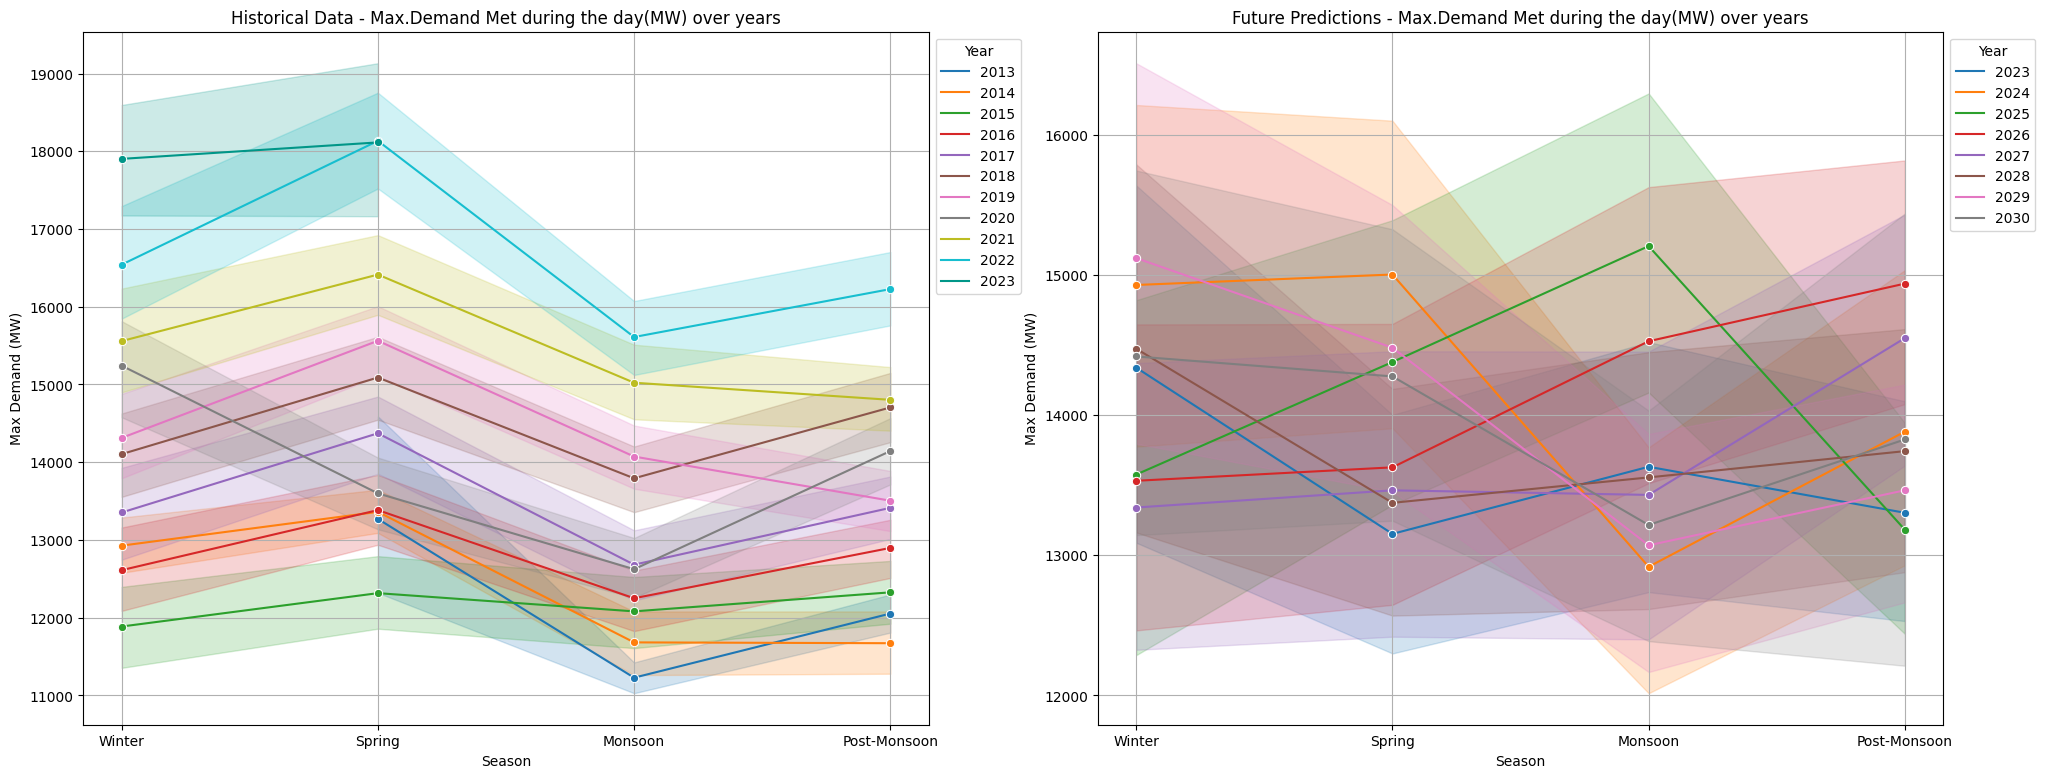

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

dataframes = [df1, future_predictions]
labels = ['Historical Data', 'Future Predictions']

fig, axes = plt.subplots(1, 2, figsize=(24, 9)) 

for i, data in enumerate(dataframes):
    custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#009688"]
    sns.lineplot(x='Season', y='Max.Demand Met during the day(MW)', hue='Year', data=data, marker='o', palette=custom_palette, ax=axes[i])
    axes[i].set_title(f'{labels[i]} - Max.Demand Met during the day(MW) over years')
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel('Max Demand (MW)')
    axes[i].grid(True)
    axes[i].legend(title='Year', loc='upper left', bbox_to_anchor=(1, 1))

plt.subplots_adjust(wspace=0.2)
plt.show()
